[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksasi/EVA/blob/master/Project11/Assignment11.ipynb)

In [0]:
# Import numpy, time, matplotlib, Keras models, backend, layers and utils
# set random seed using random.seed from numpy

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


In [0]:
# Import cifar10 from keras datasets
# Load CIFAR10 dataset from Keras datasets module seperately as train and test datasets
# Obtain number of training and testing examples, image dimensions and number of classes

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


In [0]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


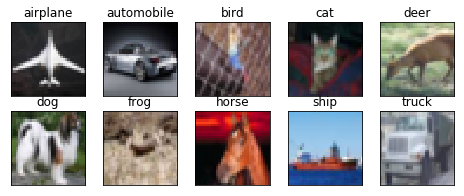

In [0]:
# Display images corresponding to each class from training dataset

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Define function to plot summarize history for accuracy and loss

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Define function to calculate accuracy

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)


### Implemented the model with below changes 
1. Using Image Normalization
2. Making use of Batch Normalization
3. Making use of L2 Regularizer
4. Properly using Dropout
5. Removed Dense layers

In [0]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) 0.01989002 1.0052702
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
# Obtain train and test dataset after applying image standardization

iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) #Input channel 3, number of filters 32, filter size is 3x3 with 3 channels. Receptive field is 3x3. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 5x5. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 64, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 10x10. Output Images size 16. This is MaxPooling layer.
model.add(Dropout(0.2)) # Droput is set to 0.2

model.add(Convolution2D(32, 1, 1)) #Input channel 64, number of filters 32, filter size is 1x1 with 64 channels. Receptive field is 10x10. Output Images size 16. This is transition block.


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))  #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 12x12. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 64, number of filters 128, filter size is 3x3 with 64 channels. Receptive field is 14x14. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 128, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 28x28. Output Images size 8. This is MaxPooling layer.
model.add(Dropout(0.3)) # Droput is set to 0.3

model.add(Convolution2D(32, 1, 1)) #Input channel 128, number of filters 32, filter size is 1x1 with 128 channels. Receptive field is 28x28. Output Images size 8. This is transition block.


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 32, number of filters 128, filter size is 3x3 with 32 channels. Receptive field is 30x30. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 128, number of filters 256, filter size is 3x3 with 128 channels. Receptive field is 32x32. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization())  # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 256, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 64x64. Output Images size 4. This is MaxPooling layer.
model.add(Dropout(0.5)) # Droput is set to 0.5

model.add(Convolution2D(10, 1, 1)) #Input channel 256, number of filters 10, filter size is 1x1 with 256 channels. Receptive field is 64x64. Output Images size 4. This is transition block.

model.add(AveragePooling2D(pool_size = (4,4))) # Average Pooling layer
model.add(Flatten()) #The outputs from the previous layer are flattened


model.add(Activation('softmax'))  #Softmax activation layer.So that the values of logits are squished between 0 and 1

# Compile the model
model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

W0718 15:46:55.934234 139864666290048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0718 15:46:55.968564 139864666290048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 15:46:55.976700 139864666290048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 15:46:56.022226 139864666290048 deprecation_wrapper.py

In [0]:
# Displays the summary of the model i.e. gives the details of different shapes and channels in different layers of the model.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Total params: 455,370

### Learning rate finder

In [0]:
# LR Finder class

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
# Create LR finder instance to find the optimum learning rate

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(X_train.shape[0]/128))

### With Cutout / Random Erasing

- https://github.com/yu4u/cutout-random-erasing

In [0]:
# Import Cutout / Random Erasing implementation, especially for ImageDataGenerator in Keras from Github (https://github.com/yu4u/cutout-random-erasing)

!git clone https://github.com/yu4u/cutout-random-erasing ./random_eraser                                                   

import sys
sys.path.append("/content/random_eraser/")

Cloning into './random_eraser'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [0]:
# Run LR rate finder to obtain necessary plots and find the optimum learning rate

from keras.preprocessing.image import ImageDataGenerator
from random_eraser import get_random_eraser


datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),samples_per_epoch = X_train.shape[0], nb_epoch = 1, callbacks=[lr_finder], verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=1, steps_per_epoch=390, epochs=1)`
  if __name__ == '__main__':
W0718 15:47:20.253282 139864666290048 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wil

Epoch 1/1
377/390 [============================>.] - ETA: 0s - loss: 3.2241 - acc: 0.2464

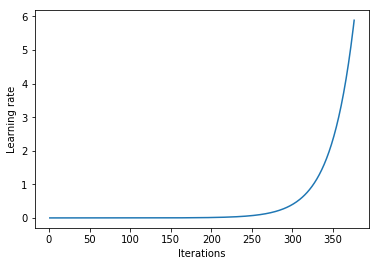

In [0]:
lr_finder.plot_lr()

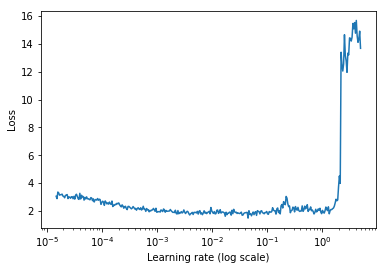

In [0]:
lr_finder.plot()

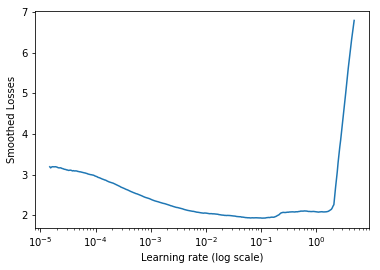

In [0]:
lr_finder.plot_smoothed_loss()

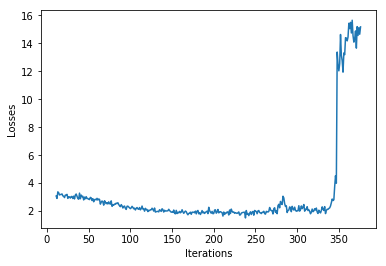

In [0]:
lr_finder.plot_loss()

#### Learning rate = 4e-4

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3))) #Input channel 3, number of filters 32, filter size is 3x3 with 3 channels. Receptive field is 3x3. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 5x5. Output Images size 32.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 64, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 10x10. Output Images size 16. This is MaxPooling layer.
model.add(Dropout(0.2)) # Droput is set to 0.2

model.add(Convolution2D(32, 1, 1)) #Input channel 64, number of filters 32, filter size is 1x1 with 64 channels. Receptive field is 10x10. Output Images size 16. This is transition block.


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 32, number of filters 64, filter size is 3x3 with 32 channels. Receptive field is 12x12. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same')) #Input channel 64, number of filters 128, filter size is 3x3 with 64 channels. Receptive field is 14x14. Output Images size 16.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2))) #Input channel 128, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 28x28. Output Images size 8. This is MaxPooling layer.
model.add(Dropout(0.3)) # Droput is set to 0.3

model.add(Convolution2D(32, 1, 1)) #Input channel 128, number of filters 32, filter size is 1x1 with 128 channels. Receptive field is 28x28. Output Images size 8. This is transition block.


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 32, number of filters 128, filter size is 3x3 with 32 channels. Receptive field is 30x30. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same')) #Input channel 128, number of filters 256, filter size is 3x3 with 128 channels. Receptive field is 32x32. Output Images size 8.
model.add(Activation('relu')) # Setup activation function as RELU
model.add(BatchNormalization()) # BatchNormalization layer

model.add(MaxPooling2D(pool_size=(2, 2)))#Input channel 256, number of filters n/a, filter size is n/a with n/a channels. Receptive field is 64x64. Output Images size 4. This is MaxPooling layer.
model.add(Dropout(0.5)) # Droput is set to 0.5

model.add(Convolution2D(10, 1, 1)) #Input channel 256, number of filters 10, filter size is 1x1 with 256 channels. Receptive field is 64x64. Output Images size 4. This is transition block.

model.add(AveragePooling2D(pool_size = (4,4)))) # Average Pooling layer
model.add(Flatten()) #The outputs from the previous layer are flattened


model.add(Activation('softmax'))  #Softmax activation layer.So that the values of logits are squished between 0 and 1

# Compile the model
model.compile(optimizer=optimizers.SGD(lr=4e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

In [0]:
# create a checkpoint to save the model when accuracy improves

from keras.callbacks import *
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  


Model took 1150.39 seconds to train


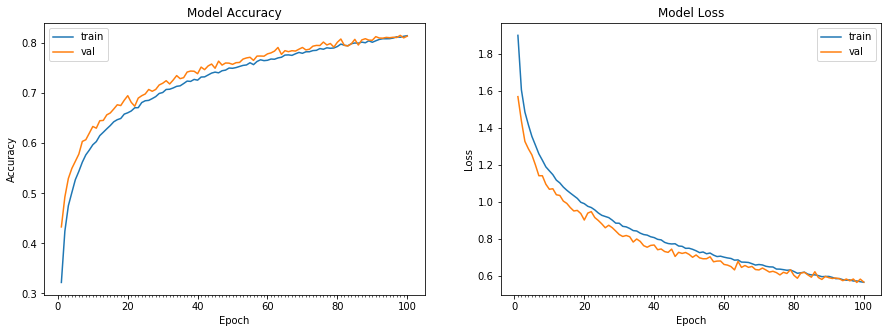

Top accuracy on test data is: 81.55


In [0]:
# Train the model using fit_generator function. Also calculate and display total time taken for training. Along with this plot summarize history for accuracy and loss. Display best validatino accuracy.

from keras.preprocessing.image import ImageDataGenerator
from random_eraser import get_random_eraser
from math import ceil
from keras.models import load_model


datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False, preprocessing_function=get_random_eraser(v_l=0, v_h=1))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = X_train.shape[0], nb_epoch = 100, validation_data = (X_test, Y_test), verbose=0, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)


saved_model = load_model('best_model.hdf5')

print ("Top accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, saved_model))

In [0]:
#Obtain predictions

y_pred = saved_model.predict(X_test)

In [0]:
# Print predictions and actual labels

print(y_pred[:9])
print(Y_test[:9])

[[1.50687271e-03 3.44691129e-04 7.09270185e-04 9.53393459e-01
  5.19722125e-05 2.82355770e-02 1.49460388e-02 4.28521389e-06
  6.10400748e-04 1.97408517e-04]
 [2.95687147e-04 1.13298921e-02 9.86172779e-08 1.32566939e-07
  5.32442925e-08 6.67784272e-09 2.59762807e-08 2.00524806e-08
  9.88366306e-01 7.73971715e-06]
 [2.71691335e-03 4.60783718e-03 3.18257116e-06 4.96966732e-06
  1.03090633e-05 5.71378962e-07 1.83164309e-06 1.68250870e-06
  9.92607474e-01 4.52392196e-05]
 [3.91046822e-01 3.58991437e-02 2.72965920e-03 2.84942263e-03
  1.45946571e-04 2.19419508e-05 3.15161451e-04 1.42831239e-04
  5.65762818e-01 1.08624320e-03]
 [3.56053147e-06 9.46858636e-05 2.66272388e-03 1.71766058e-03
  3.66683817e-04 8.37989035e-07 9.95100796e-01 2.04647286e-08
  3.51061135e-05 1.80173392e-05]
 [1.17701411e-05 2.34621639e-05 3.28834940e-05 1.12378448e-02
  8.05797405e-04 2.85621011e-03 9.84789908e-01 9.23054249e-05
  1.46774746e-05 1.35148774e-04]
 [2.64209532e-03 8.07009101e-01 1.95790839e-04 2.00517830e

In [0]:
# Calculate predicted labels and actual labels

prediction_labels = np.argmax(y_pred, axis = -1)
actual_labels = np.argmax(Y_test, axis = -1)

In [0]:
# Print predicted and actual labels

print(prediction_labels[:9])
print(actual_labels[:9])

[3 8 8 8 6 6 1 2 3]
[3 8 8 0 6 6 1 6 3]


In [0]:
# Obtain indexes of the images where the actual labels are different from the predicted labels i.e. indexes of misclassified images

mc_idx = []
for idx,val in enumerate(actual_labels):
  if val != prediction_labels[idx]:
    mc_idx.append(idx)
    
print(mc_idx[:4])

[3, 7, 9, 24]


In [0]:
# Print total number of misclassified images

print(len(mc_idx))

1845


In [0]:
print(X_test.shape)

(10000, 32, 32, 3)


In [0]:
# Obtain the list of 25 misclassified image indexes

idx_list = [mc_idx[i] for i in range(25)]
print(idx_list)

[3, 7, 9, 24, 33, 35, 37, 42, 49, 52, 57, 58, 59, 61, 76, 78, 85, 86, 91, 101, 106, 118, 125, 128, 134]


In [0]:
# Import numpy, cv2, sys, Keras image and backend
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

# Function to obtain class_output from the predictions. Model, features and indexes need to be passed as arguments.

def pred_class_info(model, features, features_std, idx):
      img = features.reshape(features.shape[0], 32, 32, 3)[idx]
      img = img.reshape(1, 32, 32, 3)
      img_std = features_std.reshape(features.shape[0], 32, 32, 3)[idx]
      img_std = img_std.reshape(1, 32, 32, 3)
      preds = model.predict(img_std)
      class_idx = np.argmax(preds)
      class_output = model.output[:, class_idx]
      return img,class_output



In [0]:
# Function to obtain weighted features map. This takes class ouput, last convoultion layer, image and number of filters as arguments

def weighted_feature_map(model, class_output, last_conv_layer, img, filters):
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([img])

  for i in range(filters):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  return conv_layer_output_value

In [0]:
# Function to generate heatmap from pooled_gradient_values * conv_layer_output

def gen_heatmap(conv_layer_output_value):
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

In [0]:
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
last_conv_layer = saved_model.get_layer("conv2d_17")

In [0]:
print(last_conv_layer.output)

Tensor("conv2d_17_1/BiasAdd:0", shape=(?, 8, 8, 256), dtype=float32)


In [0]:
# Function to obtain the gradient CAM(Class Activation Map). This takes mode, entire dataset of images, index of the image for which grad CAM is to be generated, layer name and number of filters in that layer

def grad_CAM(model, features, features_std, index, layer_nam, num_filters):
  img,class_output = pred_class_info(model, features, features_std, index)
  last_conv_layer = model.get_layer(layer_nam)
  
  conv_layer_output_value = weighted_feature_map(model, class_output, last_conv_layer, img, num_filters)
  heatmap = gen_heatmap(conv_layer_output_value)
    
  img = img.reshape(32, 32, 3)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap1 = np.uint8(255 * heatmap)
  heatmap2 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
  heatmap3 = cv2.cvtColor(heatmap2,cv2.COLOR_BGR2RGB)
  img1 = np.uint8(255 * img)
  superimposed_img = cv2.addWeighted(img1, 0.6, heatmap3, 0.4, 0)
  return superimposed_img

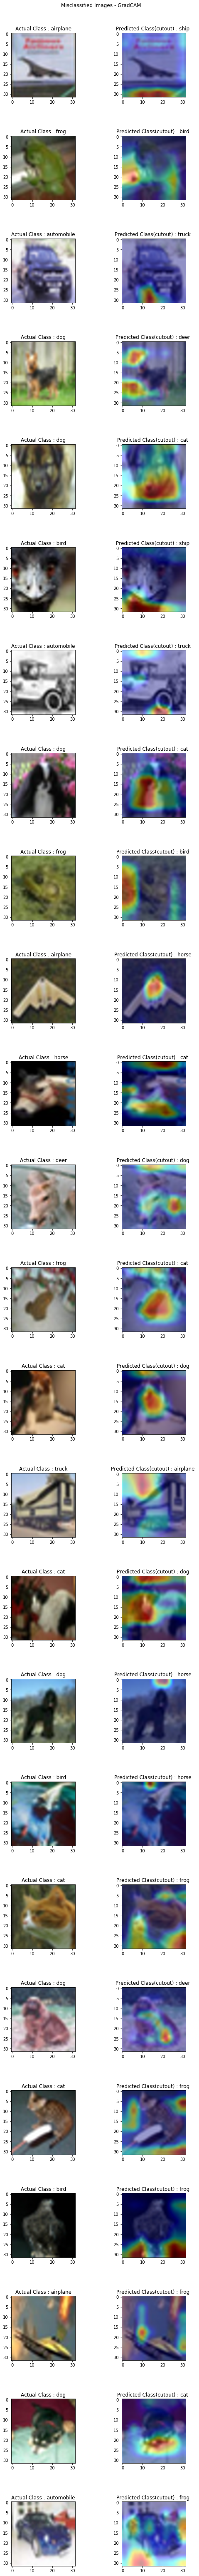

In [0]:
# Display GradCAM of 25 misclassified images

import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize=(100, 100))
spec = gridspec.GridSpec(ncols=2, nrows=25, figure=fig)
fig.tight_layout()
spec.update(top=0.97)
columns = 2
rows = 25
for i in range(rows):
  for j in range(columns):
    idx = idx_list[i] 
    img = test_features.reshape(test_features.shape[0], 32, 32, 3)[idx]
    fig.suptitle("Misclassified Images - GradCAM", horizontalalignment='left')
    fig.add_subplot(spec[i, j])
    fig.subplots_adjust(hspace= 0.6, wspace= -0.95)
    #plt.title("Actual Class : {} ; Predicted Class : {} ".format(class_names[actual_labels[idx]],  class_names[prediction_labels[idx]]))
    if j == 0:
      plt.title("Actual Class : {}".format(class_names[actual_labels[idx]]))
      plt.imshow(img,interpolation = 'spline16')
    else:
      plt.title("Predicted Class(cutout) : {} ".format(class_names[prediction_labels[idx]]))
      gradCAM_img = grad_CAM(saved_model, test_features, X_test, idx, "conv2d_17", 256)
      plt.imshow(gradCAM_img,interpolation = 'spline16')
plt.show()

### **References & Attributions:**

*   Keras (https://keras.io/)

*   Tensorflow 2.1 (https://www.tensorflow.org/api_docs/python/)


*Disclaimer: The contents of this notebook are used for educational purposes i.e. for learning and research.*